<a href="https://colab.research.google.com/github/julia254/Machine-Learning/blob/main/Sentiment_Analysis_using_imdb_movie_ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis using IMDB Movie Ratings

This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of binary classification problem in machine learning.


The Large Movie Review Dataset contains text of 50,000 movie reviews from the Internet Movie Database (IMBD). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

The dataset is sourced from [Tensorflow](https://www.tensorflow.org/datasets/catalog/imdb_reviews)

In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import string


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, TextVectorization
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt


# Load the Data

In [ ]:
imdb = tfds.load('imdb_reviews', as_supervised=True)

train_data, test_data = imdb['train'], imdb['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.BPQRNW_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.BPQRNW_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.BPQRNW_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_data.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

## Configure the dataset for performance

To prevent I/O operations from becoming a bottleneck, implement caching and prefetching:

- .cache(): This method stores the dataset in memory after loading it from disk, ensuring that data access does not slow down training.

- .prefetch(): This method allows data preprocessing to occur concurrently with model execution, improving efficiency during training.


The test data will be split into a validation and holdout set. The validation data will be used during training, and the holdout set will be used to test how the optimized model performs when predicting classes for unseen data.  

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Parameters
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Create training dataset with shuffling, caching, and batching
train_dataset = (
    train_data
    .shuffle(BUFFER_SIZE)
    .cache()  # Caching the training dataset
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Create test dataset with batching
test_dataset = (
    test_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


In [ ]:
# Calculate number of batches in test dataset
num_batches = tf.data.experimental.cardinality(test_dataset).numpy()

# Split test dataset into validation and holdout datasets
val_size = num_batches // 2
holdout_size =

# Create validation and holdout datasets
val_dataset = test_dataset.take(val_size)
holdout_dataset = test_dataset.skip(val_size)

# Apply caching and prefetching for validation and holdout datasets
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
holdout_ds = holdout_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Print the sizes of the datasets for verification
print(f"Training dataset size: {tf.data.experimental.cardinality(train_dataset).numpy()} batches")
print(f"Validation dataset size: {val_size} batches")
print(f"Holdout dataset size: {val_size} batches")


Training dataset size: 391 batches
Validation dataset size: 195 batches
Holdout dataset size: 195 batches


# Exploratory Data Analysis

The IMDB dataset contains 25,000 examples in the training and test dataset, each is balanced with equal number for examples from the two classes positive reviews (1) and negative reviews (0).

In [ ]:
train_examples = []
train_labels = []

for example, label in train_data:
  train_examples.append(str(example.numpy()))
  train_labels.append(str(label.numpy()))

train_labels = np.array(train_labels).astype('float32')

print('text: ', train_examples[0])
print('label: ', train_labels[0])

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0.0


In [ ]:
print("Label 0 corresponds to", 'negative')
print("Label 1 corresponds to", 'positive')


Label 0 corresponds to negative
Label 1 corresponds to positive


In [ ]:
print("number of items in examples data:", len(train_examples) )
print("number of items in label data:", len(train_labels) )

number of items in examples data: 25000
number of items in label data: 25000


In [ ]:
values, counts = np.unique(train_labels, return_counts = True)

print('number of items in class 0:', counts[0] )
print('number of items in class 1:', counts[1] )

number of items in class 0: 12500
number of items in class 1: 12500


In [ ]:
test_examples = []
test_labels = []

for example, label in test_data:
  test_examples.append(str(example.numpy()))
  test_labels.append(str(label.numpy()))

test_labels = np.array(test_labels).astype('float32')

print('text: ', test_examples[0])
print('label: ', test_labels[0])

text:  b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."
label:  1.0


In [ ]:
df_test = pd.DataFrame({'text': test_examples,
                       'target': test_labels})

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    25000 non-null  object 
 1   target  25000 non-null  float32
dtypes: float32(1), object(1)
memory usage: 293.1+ KB


In [ ]:
df_test

,text,target
0,"b""There are films that make careers. For Georg...",1.0
1,"b""A blackly comic tale of a down-trodden pries...",1.0
2,"b'Scary Movie 1-4, Epic Movie, Date Movie, Mee...",0.0
3,b'Poor Shirley MacLaine tries hard to lend som...,0.0
4,b'As a former Erasmus student I enjoyed this f...,1.0
...,...,...
24995,"b""Feeling Minnesota is not really a road movie...",0.0
24996,"b'This is, without doubt, one of my favourite ...",1.0
24997,"b""Most predicable movie I've ever seen...extre...",0.0
24998,"b""It's exactly what I expected from it. Relaxi...",1.0


### Length of Text

The reviews for both training and testign datasets are on average, 230 words per review, both for the positive and negative reviews.

In [ ]:
df = pd.DataFrame({'text': train_examples,
                   'target': train_labels})

df['split_text'] = [ string.split() for string in df['text'] ]
df['text_len'] = [len(string) for string in df['split_text']]

<Axes: xlabel='target', ylabel='text_len'>

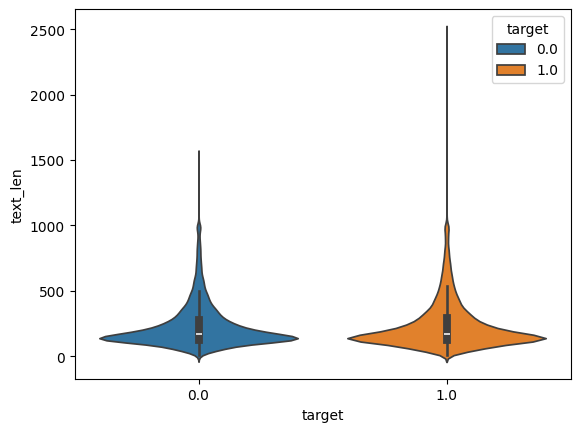

In [ ]:
import seaborn as sns
sns.violinplot(data=df, x ='target', y = 'text_len', hue = 'target')

In [ ]:
print("Training Data Text Size")
print()
print ("Average Length Class 0:", df.loc[df['target'] == 0, 'text_len'].mean() )
print ("Average Length Class 1:", df.loc[df['target'] == 1, 'text_len'].mean() )
print()
print ("Max Length Class 0:", df.loc[df['target'] == 0, 'text_len'].max() )
print ("Max Length Class 1:", df.loc[df['target'] == 1, 'text_len'].max() )
print()
print ("Min Length Class 0:", df.loc[df['target'] == 0, 'text_len'].min() )
print ("Min Length Class 1:", df.loc[df['target'] == 1, 'text_len'].min() )


Training Data Text Size

Average Length Class 0: 230.85776
Average Length Class 1: 236.69568

Max Length Class 0: 1522
Max Length Class 1: 2470

Min Length Class 0: 10
Min Length Class 1: 12


In [ ]:
print("Test Data Text Size")
print()

df_test['split_text'] = [ string.split() for string in df['text'] ]
df_test['text_len'] = [len(string) for string in df['split_text']]

print ("Average Length Class 0:", df_test.loc[df_test['target'] == 0, 'text_len'].mean() )
print ("Average Length Class 1:", df_test.loc[df_test['target'] == 1, 'text_len'].mean() )
print()
print ("Max Length Class 0:", df_test.loc[df_test['target'] == 0, 'text_len'].max() )
print ("Max Length Class 1:", df_test.loc[df_test['target'] == 1, 'text_len'].max() )
print()
print ("Min Length Class 0:", df_test.loc[df_test['target'] == 0, 'text_len'].min() )
print ("Min Length Class 1:", df_test.loc[df_test['target'] == 1, 'text_len'].min() )


Test Data Text Size

Average Length Class 0: 233.57864
Average Length Class 1: 233.9748

Max Length Class 0: 2470
Max Length Class 1: 1839

Min Length Class 0: 10
Min Length Class 1: 10


In [ ]:
df.head()

,text,target,split_text,text_len
0,"b""This was an absolutely terrible movie. Don't...",0.0,"[b""This, was, an, absolutely, terrible, movie....",116
1,b'I have been known to fall asleep during film...,0.0,"[b'I, have, been, known, to, fall, asleep, dur...",112
2,b'Mann photographs the Alberta Rocky Mountains...,0.0,"[b'Mann, photographs, the, Alberta, Rocky, Mou...",132
3,b'This is the kind of film for a snowy Sunday ...,1.0,"[b'This, is, the, kind, of, film, for, a, snow...",88
4,"b'As others have mentioned, all the women that...",1.0,"[b'As, others, have, mentioned,, all, the, wom...",81


# Prepare Text Data for Training

The reviews contain raw text with punctuation and occasional HTML tags. The text must be preprocessed and converted from their string format to a numeric representation of the text. The keras TextVectorization layer will help to standardize, tokenize, and vectorize the text data.  

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements. Tokenization refers to splitting strings into tokens. In other words, breaking down a sentence into individual words. Vectorization refers to converting tokens into numbers so they can be fed into a neural network. Once TextVectorizer output is produced, it will be passed through the Keras Embedding layer which will predict the word embedding for each token.

It is important to preprocess the data identically at training and testing phases of learning to prevent training-testing skew.

In [ ]:
VOCAB_SIZE = 3000
#sequence_length = 250

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
# Standardize, Tokenize, Vectorize
encoder = TextVectorization(
    standardize=custom_standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int')


# Set the layer's vocabulary
encoder.adapt(train_dataset.map(lambda text, label: text))

TextVectorization comes with limited options for standardizing text, namely converting text to lowercase and removing punctuation. The movie ratings dataset contains additional unwanted characters that need to be removed. This can be handled using a custom standardization procedure.

The adapt method will build a vocabulary based on the movie rating corpus.By using max_token arguement, the vocabulary size can be restricted to include only to the most frequent terms.  Below is a list of the top 20 most frequent terms.

In [ ]:
# Get top 20 most frequent terms in the created vocabulary

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film'],
      dtype='<U14')

Once the vocabulary is set, the TextVectorization layer converts each word in the text to its corresponding index based on the vocabulary. Each word in a review is represented by this index and the resulting sequences are zero-padded to match the lenght of the longest sequence in the batch. Alternatively, you can specify a fixed sequence length. The output, which consists of these word indices, is then passed through the Embedding layer, where each word is mapped to its unique word embedding.

In [ ]:
# Tensor of indices for each review
# Zero padding is applied to ensure
# the batches have the same sequence length

encoded_example = encoder(train_examples)[:3].numpy()
print(encoded_example)
print(encoded_example.shape)

[[ 1 13 33 ...  0  0  0]
 [ 1 25 74 ...  0  0  0]
 [ 1  1  2 ...  0  0  0]]
(3, 2459)


The limited vocabulary size and lack of character-based fallback results in some unknown tokens. When we have an Out of Vocabylary (OOV) word it is marked as an UNK token [UNK].

In [ ]:
for n in range(2):
  print("Original: ", train_examples[n])
  print()
  print("Processed: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

Processed:  [UNK] was an absolutely terrible movie dont be [UNK] in by christopher [UNK] or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not [UNK] this movies ridiculous storyline this movie is an early

# Define the model

A recurrent neural network architecture, LSTM, followed by a fully connected layer was tested for sentiment analysis of the IMDB ratings. The architecture  LSTM layer with tanh activation followed by a dropout layer, dense layer, dropout layer followed by a dense layer

The following hyperparameters were optimized to minimize the loss function:
- Number of RNN Layers
- Number of RNN Units
- Number dense layers
- Number of dense units
- Dropout Rate
- Learning Rate

In [ ]:
def model_builder(hp):
  model = Sequential()

  model.add(encoder)
  model.add(Embedding(input_dim = len(encoder.get_vocabulary()),
                    output_dim = 64,
                    mask_zero = True))

   # Hyperparameter for number of RNN layers and rnn units in RNN cell
  num_rnn_layers = hp.Int('num_rnn_layers', min_value=1, max_value=3, step=1)
  rnn_units = hp.Int('units', min_value=1, max_value=100, step=5)
  drop_rate_rnn = hp.Float('rate_rnn', min_value=0.1, max_value=0.5, step=0.1)

  for _ in range(num_rnn_layers):
    model.add(LSTM(rnn_units, activation = 'tanh',
                       return_sequences=True if _ < num_rnn_layers - 1 else False))
    model.add(Dropout(rate = drop_rate_rnn))

  # Hyperparameter for number of Dense layers and Dense Units
  num_dense_layers = hp.Int('dense_layers', min_value = 1, max_value = 5, step = 1)
  hp_dense_units = hp.Int('dense_units',min_value = 32, max_value = 512, step = 32)
  drop_rate_dense = hp.Float('rate_dense', min_value=0.1, max_value=0.5, step=0.1)

  for _ in range(num_dense_layers):
    model.add(Dense(units=hp_dense_units, activation='relu'))
    model.add(Dropout(rate = drop_rate_dense))

  # Output Layer
  model.add(Dense(1, activation='sigmoid'))

  # Tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

### Hyperparameter Tuning

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=os.getcwd(),
                     project_name='sentiment_analysis')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_dataset,  epochs=3, validation_data=val_dataset, callbacks=[stop_early])

Trial 30 Complete [00h 01m 57s]
val_accuracy: 0.8632211685180664

Best val_accuracy So Far: 0.8857371807098389
Total elapsed time: 00h 48m 27s


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

for key, value in best_hps.values.items():
  print(key,':', value)

num_rnn_layers : 2
units : 86
rate_rnn : 0.1
dense_layers : 1
dense_units : 256
rate_dense : 0.2
learning_rate : 0.01
tuner/epochs : 4
tuner/initial_epoch : 0
tuner/bracket : 1
tuner/round : 0


# Train the model

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 30 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset)


Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - accuracy: 0.6164 - loss: 0.6437 - val_accuracy: 0.8513 - val_loss: 0.3399
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.8690 - loss: 0.3206 - val_accuracy: 0.8596 - val_loss: 0.3263
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.8979 - loss: 0.2570 - val_accuracy: 0.8700 - val_loss: 0.3091
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.9170 - loss: 0.2110 - val_accuracy: 0.8687 - val_loss: 0.3476
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.9283 - loss: 0.1874 - val_accuracy: 0.8580 - val_loss: 0.3872
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.9375 - loss: 0.1639 - val_accuracy: 0.8781 - val_loss: 0.3486
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.9448 - loss: 0.1531 - val_accuracy: 0.8651 - val_loss: 0.4535
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9483 - loss: 0.1441 - 

In [ ]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 6


In [ ]:
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=val_dataset)

Epoch 1/6
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.6001 - loss: 0.6488 - val_accuracy: 0.8400 - val_loss: 0.3780
Epoch 2/6
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.8564 - loss: 0.3461 - val_accuracy: 0.8693 - val_loss: 0.3151
Epoch 3/6
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.8877 - loss: 0.2811 - val_accuracy: 0.8679 - val_loss: 0.3055
Epoch 4/6
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.9090 - loss: 0.2384 - val_accuracy: 0.8760 - val_loss: 0.2966
Epoch 5/6
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.9223 - loss: 0.2042 - val_accuracy: 0.8774 - val_loss: 0.3002
Epoch 6/6
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.9330 - loss: 0.1815 - val_accuracy: 0.8689 - val_loss: 0.3489


# Evaluate the model

In [ ]:
test_loss, test_acc = hypermodel.evaluate(val_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8681 - loss: 0.3528
Test Loss: 0.3489391505718231
Test Accuracy: 0.8689102530479431


# Predictions on New Data

In [ ]:
predictions = model.predict(holdout_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step


In [ ]:
y_pred = (predictions > 0.5).astype('int').flatten().reshape(-1,1)

y_pred.shape

(12520, 1)

In [ ]:
# Extract labels from the holdout dataset
holdout_labels = []
for _, label in holdout_dataset:
    holdout_labels.append(label.numpy())

# Convert the list to a numpy array if needed
y_true = np.concatenate(holdout_labels).reshape(-1,1)

y_true.shape

(12520, 1)

In [45]:
# Instantiate metrics
p = tf.keras.metrics.Precision()
r = tf.keras.metrics.Recall()
f = tf.keras.metrics.F1Score()
a = tf.keras.metrics.AUC()

# Update the state with true and predicted labels
p.update_state(y_true, y_pred)
r.update_state(y_true, y_pred)
f.update_state(y_true, y_pred)
a.update_state(y_true, y_pred)


# Results

### Hyperparameter Tuning

Hyperparameter search was conducted using the Keras Hyperband algorithm. It found the following optimal parameters:
- RNN Layers:2, given choice of 1, 2, 3 layers
- RNN Units:86, given choice between 1 and 100 units per cell
- RNN Dropout rate: 0.1, given choice between 0.1 and 0.5
- Dense layers: 1., given choice of 1, 2, 3 layers
- Dense units: 256, given choice between 32 and 512
- Dense Dropout Rate: 0.2,  given choice between 0.1 and 0.5
- Learning Rate: 0.1, given choice between 0.01, 0.001, 0.0001

Hyperparameter search found that the mid range number of RNN layers, large number of RNN units, low dropout and learning rates, and one dense layer with mid-range number of units were the optimal hyperparameters for my neural network architecture.

### Training and Validation Metrics

The plot below shows that the performance of the best model optimized using Keras-Tuner. It displays the loss and accuracy at each epoch of the training and validation phases.

The best training accuracy reached was 0.97 while the lowest validation accuracy reached was 0.87. On the other hand, the lowest training loss was 0.06 while the lowest validation loss was 0.34. For both accuracy and loss measures, the differences between training and validation is large. This observation that suggest that the model is overfitting and not generalizing well on unseen data.




In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

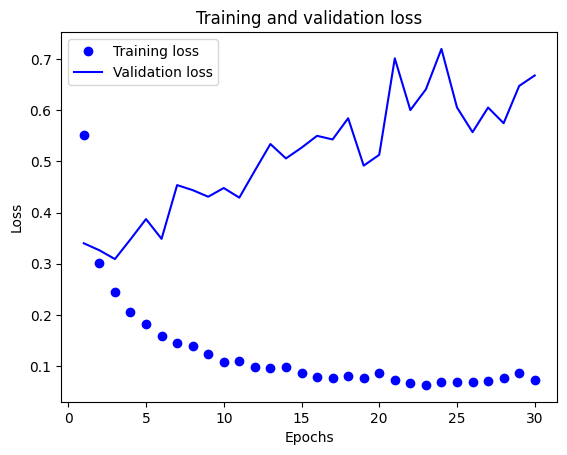

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

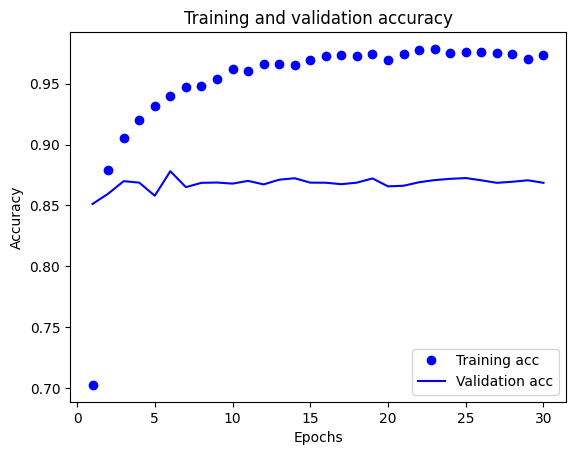

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Prediction on unseen data

Performance metrics precision, recall, F1 score, and AUC were used to test how the model performs when it is fed data is has not seen. The results below show that the best performing models achieved around 0.87 for all metrics when predicting new data.

In [46]:
# Calculate and print the results
print('Precision:', p.result().numpy())
print('Recall:', r.result().numpy())
print('F1 Score:', f.result().numpy())
print('AUC:', a.result().numpy())

Precision: 0.8749801
Recall: 0.8717867
F1 Score: [0.8733805]
AUC: 0.8727702


# Conclusion


The predictions of the implemented neural architecture achieved a very modest performance with precision, recall, F1 score and AUC of around 0.87. This suggests that LSTM combined with a fully connected layer can reliably give sentiment of a movie review, although a few reviews will result in a few inaccurate predictions.  

Finding parameter configurations that would increase the validation accuracy was a challenge. Adding dropout rate after the LSTM layer and Dense layer did not improve validation accuracy. This combined with early stopping did not prevent overfitting.

Any improvements to the model would largely be focused on addressing the overfitting problem, seen here as the discrepancy in accuracy and loss measures between training and validation data. Applying various techniques regularization methods such as weight decay could improve the model's generaralization.

